# 2. Advanced Convolution

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Pillow (tested on v9.3.0)
- Scipy (tested on v1.9.3)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Scipy
from scipy.signal import correlate
# Torch
import torch
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST

### Loading an image for testing

As in the previous notebook.

In [2]:
# Open the image and convert it to grayscale
im = Image.open('flower.jpg').convert('L')

# Convert the image to a NumPy array
im_array = np.array(im)

# Print the shape of the array
print(im_array.shape)

(459, 612)


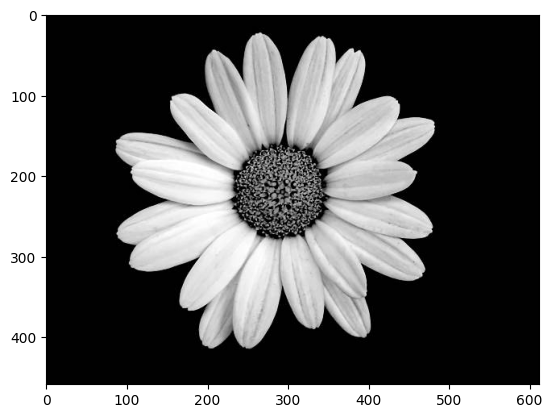

In [3]:
# Display image in matplotlib
plt.imshow(im_array, cmap = 'gray')
plt.show()

### Adding padding

A typical problem with the convolution operation we defined earlier and that we recall in the function below is that it produces an image whose size/resolution has been reduced. This has to do with the kernel being used, which sums several pixels together, but only produces one pixel as a result. This effect is increased with the size of the kernel being used.

In [4]:
# Our convolution function
def convolution_basic(image, kernel):
    # Flip the kernel (optional)
    kernel = np.flipud(np.fliplr(kernel))
    
    # Get the dimensions of the image and kernel
    image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape
    
    # Convolve using Numpy
    output = correlate(image, kernel, mode = 'valid')
    
    return output

A typical way to address this issue consists of **padding** the image, that is, adding some extra pixels on the outer part of the image (these pixels will typically have a value 0), eventually increasing the size of the original image, so that the convolution operation will eventually produce an output image whose size matches the size of the original image. This can also be used to maintain the spatial dimensions of the input image and prevent the spatial dimensions of the output from getting too small.

We can implement it below.

In [5]:
def convolution_with_padding(image, kernel, padding = 0):
    # Flip the kernel (optional)
    kernel = np.flipud(np.fliplr(kernel))
    
    # Get the dimensions of the image and kernel
    image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape
    
    # Add padding to the image
    image = np.pad(image, ((padding, padding), (padding, padding)), 'constant')
    
    # Set the output image to the correct size
    output_rows = image_rows - kernel_rows + 1
    output_cols = image_cols - kernel_cols + 1
    output = np.zeros((output_rows, output_cols))
    
    # Convolve using Numpy
    output = correlate(image, kernel, mode = 'valid')
    
    return output

In [6]:
# Blur (no padding)
kernel = np.array([[1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])/25
image_conv = convolution_basic(im_array, kernel)
# Print the shape of the array
print(im_array.shape)
print(image_conv.shape)

(459, 612)
(455, 608)


In [7]:
# Blur (same padding)
kernel = np.array([[1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])/25
image_conv_pad = convolution_with_padding(im_array, kernel, padding = 2)
# Print the shape of the array
print(im_array.shape)
print(image_conv_pad.shape)

(459, 612)
(459, 612)


### Adding stride

The purpose of **stride** in convolution is to control the movement or step size of the convolution filter as it slides over the input image. A larger stride results in a smaller output feature map, while a smaller stride results in a larger output feature map. Stride can also be used to reduce the spatial dimensions of the feature map, which can help to reduce the number of parameters and computation in the network.

Using a stride that is not 1, will drastically reduce the size of the output image, so beware!

In [8]:
def convolution_with_stride_and_padding(image, kernel, stride = 1, padding = 0):
    # Flip the kernel (optional)
    kernel = np.flipud(np.fliplr(kernel))
    
    # Get the dimensions of the image and kernel
    image_rows, image_cols = image.shape
    kernel_rows, kernel_cols = kernel.shape
    
    # Add padding to the image
    image = np.pad(image, ((padding, padding), (padding, padding)), 'constant')
    
    # Set the output image to the correct size
    output_rows = (image_rows - kernel_rows) // stride + 1
    output_cols = (image_cols - kernel_cols) // stride + 1
    output = np.zeros((output_rows, output_cols))
    
    # Convolve using Numpy
    # (not the most optimal way to implement it but good enough!)
    output = correlate(image, kernel, mode = 'valid')[::stride, ::stride]
    
    return output

In [9]:
# Blur (with stride and padding)
kernel = np.array([[1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])/25
image_conv_pad_stride = convolution_with_stride_and_padding(im_array, \
                                                            kernel, \
                                                            stride = 2, \
                                                            padding = 2)
# Print the shape of the array
print(im_array.shape)
print(image_conv_pad_stride.shape)

(459, 612)
(230, 306)


### The magic formula for convolution

The output size of an image after a convolution operation is determined by the size of the image $ I $, the size of the kernel $ K $, the stride $ S $, and the padding $ P $. The formula for calculating the output size $ O $ of an image after a convolution operation is as follows:

$$ O = \frac{I - K + 2P}{S} + 1 $$

This formula applies to both the width and height dimensions of the image.

For example, let us consider an input image of size (15, 20) and you apply a kernel of size (3, 3) with a stride of 2 and padding of 1. The output size is calculated as follows:

$$ O_{rows} = \frac{15 - 3 + 2 * 1}{2} + 1 = 7 $$ 

$$ O_{cols} = \frac{20 - 3 + 2 * 1}{2} + 1 = 9 $$ 

The output image will then have size (7, 9).

It is important to note that this formula assumes that the input size, kernel size, stride, and padding are all integers. If any of these values are not integers, you may need to use additional rounding or truncation to obtain the final output size.

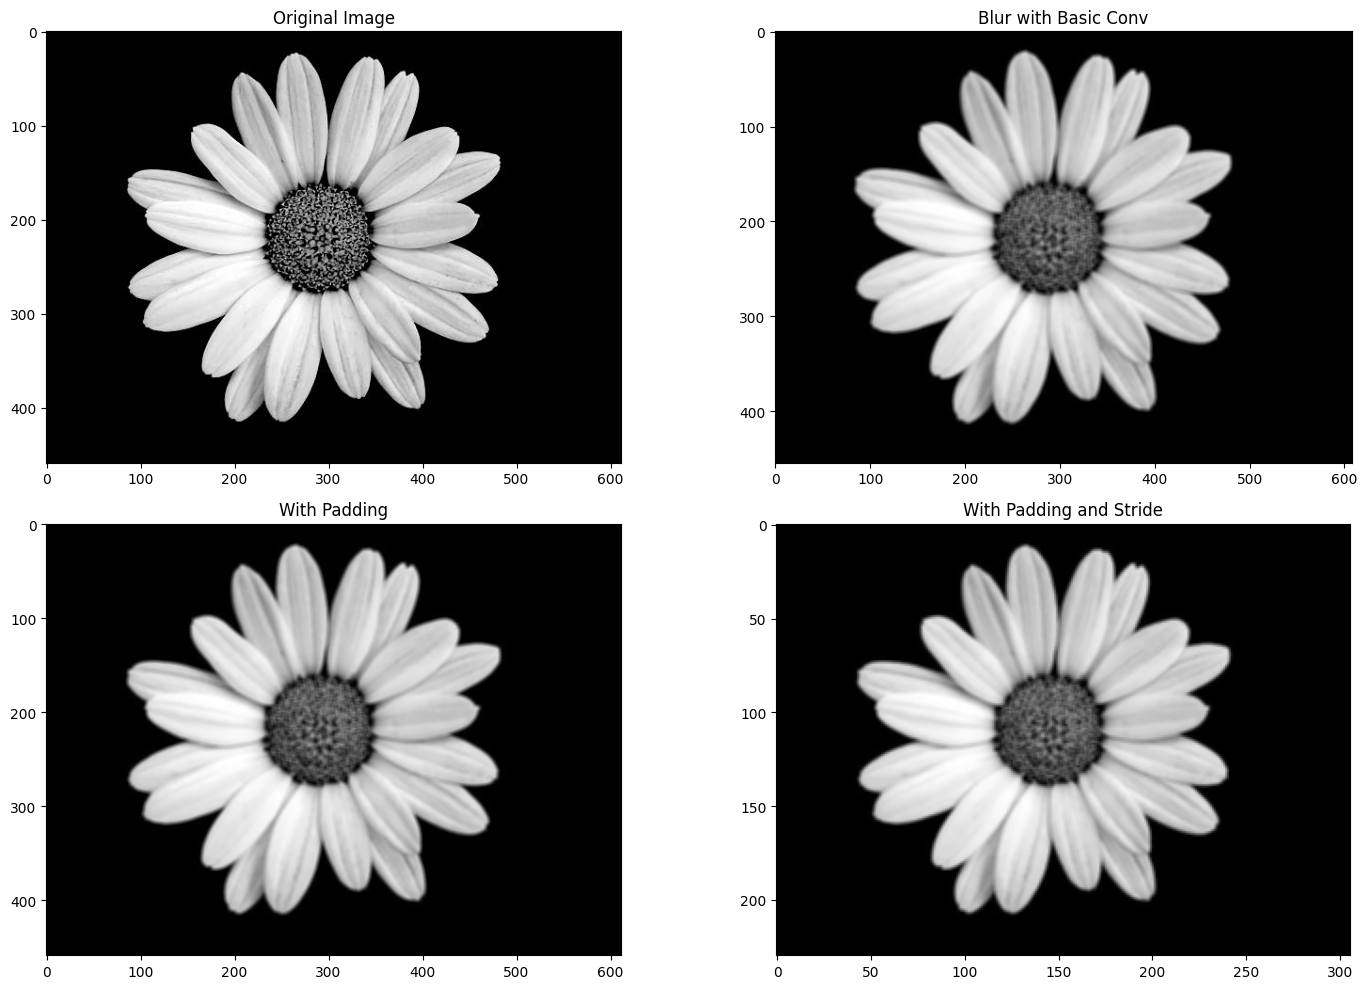

In [10]:
# Display all
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

# Display the images
axes[0, 0].imshow(im_array, cmap = 'gray')
axes[0, 0].set_title('Original Image')
axes[0, 1].imshow(image_conv, cmap = 'gray')
axes[0, 1].set_title('Blur with Basic Conv')
axes[1, 0].imshow(image_conv_pad, cmap = 'gray')
axes[1, 0].set_title('With Padding')
axes[1, 1].imshow(image_conv_pad_stride, cmap = 'gray')
axes[1, 1].set_title('With Padding and Stride')

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()

### PyTorch version of this convolution

As we have seen, this convolution operation is of high interest for us when it comes to processing images.

We would definitely be interested to implement the convolution in PyTorch to eventually improve the speed and eventually reuse it in our neural networks: the kernel would then be a trainable parameter and its values could be calculated/updated by a gradient descent algorithm of some sort (after all convolution is just another matrix multiplication of some sort!).

We implement it below.

In [11]:
def convolution_with_stride_and_padding_torch(image, kernel, stride = 1, padding = 0):
    # Convert image and kernel to PyTorch tensors
    image = torch.from_numpy(image)
    kernel = torch.from_numpy(kernel)
    
    # Flip the kernel (optional)
    kernel = torch.flip(torch.flip(kernel, [0]), [1])
    
    # Add padding to the image
    image = torch.nn.functional.pad(image, (padding, padding, padding, padding))
    
    # Set the output image to the correct size
    output_rows = (image.shape[0] - kernel.shape[0]) // stride + 1
    output_cols = (image.shape[1] - kernel.shape[1]) // stride + 1
    output = torch.zeros((output_rows, output_cols))
    
    # Convolve using PyTorch
    for i in range(0, output_rows, stride):
        for j in range(0, output_cols, stride):
            output[i, j] = (kernel * image[i:i + kernel.shape[0], j:j + kernel.shape[1]]).sum()
            
    return output

In [12]:
# Blur
kernel = np.array([[1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])/25

# Numpy and torch implementations comparison
image_conv_pad_stride = convolution_with_stride_and_padding(im_array, kernel, stride = 2, padding = 2)
image_conv_pad_stride_torch = convolution_with_stride_and_padding_torch(im_array, kernel, stride = 2, padding = 2)
# Print the shape of the array
print(im_array.shape)
print(image_conv_pad_stride.shape)
print(image_conv_pad_stride_torch.shape)

(459, 612)
(230, 306)
torch.Size([230, 306])


### Using convolution on a batch of images and its Conv2d equivalent

Eventually, we could amend our function, so that it operates with batches of images, instead of single ones.

For instance, if my input consists of $ N = 100 $ images, greyscale using $ K = 1 $ channels (RGB would have 3), and images are of size $ 30 \times 20 $, then my input *images* would be a tensor of size $ (100, 1, 30, 20) $. The function would then have to produce a tensor of size $ (100, 1, x, y) $, the last two values $ (x,y) $ being decided by our magic formula above, based on our choice of kernel, padding and stride.

In [13]:
def convolution_batch_torch(images, kernel, stride = 1, padding = 0):
    # Convert image and kernel to PyTorch tensors, if needed.
    # (Note: we will be using it on the MNIST dataset from earlier,
    # which already produces tensor images)
    #images = torch.from_numpy(images)
    kernel = torch.from_numpy(kernel)
    
    # Get the batch size (first dimension of images)
    
    # Flip the kernel (optional)
    kernel = torch.flip(torch.flip(kernel, [0]), [1])
    
    # Add padding to the image
    images = torch.nn.functional.pad(images, (padding, padding, padding, padding))
    
    # Set the output image to the correct size
    output_rows = (images.shape[2] - kernel.shape[0]) // stride + 1
    output_cols = (images.shape[3] - kernel.shape[1]) // stride + 1
    output = torch.zeros((images.shape[0], output_rows, output_cols))
    
    # Convolve using PyTorch
    # (Feel free and try to vectorize it!)
    for n in range(images.shape[0]):
        for i in range(0, output_rows, stride):
            for j in range(0, output_cols, stride):
                output[n, i, j] = (kernel * images[n, :, i:i + kernel.shape[0], j:j + kernel.shape[1]]).sum()
    
    # Reshape
    output = output.reshape(256, images.shape[1], 24, 24)
    
    return output

The above operation can however be rewritten simply and more efficacely by using the **Conv2d** function from PyTorch. It replaces the nested for loops above with a more efficient and vectorized implementation.

In [14]:
def convolution_batch_torch_conv2d(images, kernel, stride = 1, padding = 0):
    
    # Convert kernel to PyTorch tensor, if needed
    kernel = torch.from_numpy(kernel)
    kernel = kernel.view(1, 1, kernel.shape[0], kernel.shape[1])
    kernel = kernel.float()
    
    # Flip the kernel (optional)
    kernel = torch.flip(torch.flip(kernel, [2]), [3])
    
    # Create a convolutional layer
    conv = torch.nn.Conv2d(in_channels = images.shape[1], \
                           out_channels = 1, \
                           kernel_size = kernel.shape[2:], \
                           stride = stride, \
                           padding = padding)
    
    # Assign the kernel to the layer
    conv.weight = torch.nn.Parameter(kernel)
    conv.bias = torch.nn.Parameter(torch.tensor([0.0]))
    
    # Perform convolution
    output = conv(images)
    
    return output

We can typically try it, with samples from our MNIST dataloader to see both functions at work.

In [15]:
# Define transform to convert images to tensors and normalize them
transform_data = Compose([ToTensor(),
                          Normalize((0.1307,), (0.3081,))])

# Load the data
batch_size = 256
train_dataset = MNIST(root='./mnist/', train = True, download = True, transform = transform_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

# Blur
kernel = np.array([[1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1]])/25

# Draw a single batch and try
# (Very slow!)
for inputs, _ in train_loader:
    outputs = convolution_batch_torch(inputs, kernel)
    outputs2 = convolution_batch_torch_conv2d(inputs, kernel)
    print(inputs.shape)
    print(outputs.shape)
    print(outputs2.shape)
    break

torch.Size([256, 1, 28, 28])
torch.Size([256, 1, 24, 24])
torch.Size([256, 1, 24, 24])


### What's next?

**Important note:** the implementations provided here, only work for grayscale images and 2D kernels. We leave it to the students to adjust these functions so they can operate with RGB images and 3D kernels with the same behavior we have discussed in class!

In the next notebook, we will reuse this Conv2d operation and implement it in a neural network in place of the fully connected operation.